<a href="https://colab.research.google.com/github/pedromperezc/CEIA/blob/master/AP/Desafio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importar lo necesario

In [2]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
import tqdm

#### configuramos el `device` acorde al device disponible




In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Cargar base de datos

In [4]:
train= pickle.load( open( "/content/drive/MyDrive/DEEP_LEARNING/train.pkl", "rb" ) )
train_label= pickle.load( open( "/content/drive/MyDrive/DEEP_LEARNING/train_label.pkl", "rb" ) )

In [5]:
train = train.reshape(56000, 1, 28,28)

In [6]:
train.shape, train_label.shape

((56000, 1, 28, 28), (56000,))

In [7]:
test= pickle.load( open( "/content/drive/MyDrive/DEEP_LEARNING/test.pkl", "rb" ) )
test_label= pickle.load( open( "/content/drive/MyDrive/DEEP_LEARNING/test_label.pkl", "rb" ) )

In [8]:
test.shape, test_label.shape

((7000, 28, 28), (7000,))

In [9]:
test = test.reshape(7000, 1, 28,28)

In [10]:
val= pickle.load( open( "/content/drive/MyDrive/DEEP_LEARNING/val.pkl", "rb" ) )
val_label= pickle.load( open( "/content/drive/MyDrive/DEEP_LEARNING/val_label.pkl", "rb" ) )

In [11]:
val.shape, val_label.shape

((7000, 28, 28), (7000,))

In [12]:
val = val.reshape(7000, 1, 28,28)

## Transformaciones:

In [13]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(trainset.data.min(), trainset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(trainset.data.float().mean(), trainset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(trainset.data.float().mean() / 255, trainset.data.float().std() / 255))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


In [ ]:
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(train.float().mean(), train.float().std()))


In [14]:
transformacion = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.Normalize((0.1306),(0.3081))
          ])

## Dataset

In [15]:
class CustomTensorDataset(Dataset):
  def __init__(self, dataset, transform_list=None):
    [data_X, data_y] = dataset
    X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
    #X_tensor, y_tensor = Tensor(data_X), Tensor(data_y)
    tensors = (X_tensor, y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.transforms = transform_list

  def __getitem__(self, index):
    x = self.tensors[0][index]

    if self.transforms:
      #for transform in self.transforms: 
      #  x = transform(x)
      x = self.transforms(x)

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

In [16]:
train_dataset = CustomTensorDataset((torch.Tensor(train).to(device), torch.Tensor(train_label).to(device)),transform_list=transformacion )
test_dataset = CustomTensorDataset((torch.Tensor(test).to(device), torch.Tensor(test_label).to(device)),transform_list=transformacion )
val_dataset = CustomTensorDataset((torch.Tensor(val).to(device), torch.Tensor(val_label).to(device)),transform_list=transformacion )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [17]:
# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

}

2. Ver que la base de datos esté OK

In [18]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([256, 1, 32, 32])
Labels batch shape: torch.Size([256])
tamaño de 1 imagen:  torch.Size([1, 32, 32])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([32, 32])


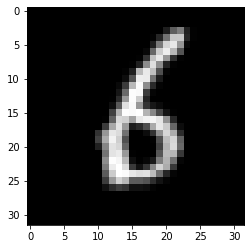

Label: 6.0


In [19]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img.cpu() , cmap="gray")
plt.show()
print(f"Label: {label}")

3. Arquitectura LeNet5 

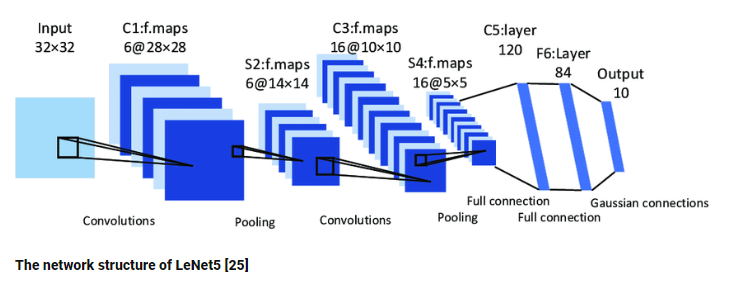

In [20]:
class LeNet5_norm(torch.nn.Module):

    def __init__(self):
        super(LeNet5_norm, self).__init__()
        
        self.convolutional_layer = torch.nn.Sequential(            
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.BatchNorm2d(6),

            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            torch.nn.ReLU()
        )

        self.linear_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(84),
            torch.nn.Linear(in_features=84, out_features=10),
        )

        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
        
        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        x = F.softmax(x, dim=1)
        return x

In [25]:
model2 = LeNet5_norm().to(device)

Número total de capas de CNN (conv+act+polling) + finales :  2
Número total de parámetros a entrenar:  61886


In [26]:
model2

LeNet5_norm(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [27]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y.long())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y.long())
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


In [28]:
fit(model2, dataloader)

val_loss 1.50874 val_acc 0.95442: 100%|██████████| 28/28 [00:01<00:00, 16.81it/s]


Epoch 1/15 loss 1.51662 val_loss 1.50874 acc 0.95793 val_acc 0.95442


val_loss 1.49247 val_acc 0.96976: 100%|██████████| 28/28 [00:01<00:00, 17.19it/s]


Epoch 2/15 loss 1.48133 val_loss 1.49247 acc 0.98105 val_acc 0.96976


val_loss 1.47964 val_acc 0.98203: 100%|██████████| 28/28 [00:01<00:00, 16.99it/s]


Epoch 3/15 loss 1.47916 val_loss 1.47964 acc 0.98275 val_acc 0.98203


val_loss 1.48359 val_acc 0.97824: 100%|██████████| 28/28 [00:01<00:00, 16.24it/s]


Epoch 4/15 loss 1.47532 val_loss 1.48359 acc 0.98630 val_acc 0.97824


val_loss 1.47753 val_acc 0.98370: 100%|██████████| 28/28 [00:01<00:00, 16.94it/s]


Epoch 5/15 loss 1.47502 val_loss 1.47753 acc 0.98633 val_acc 0.98370


val_loss 1.47667 val_acc 0.98426: 100%|██████████| 28/28 [00:01<00:00, 16.94it/s]


Epoch 6/15 loss 1.47345 val_loss 1.47667 acc 0.98765 val_acc 0.98426


val_loss 1.47633 val_acc 0.98465: 100%|██████████| 28/28 [00:01<00:00, 16.96it/s]


Epoch 7/15 loss 1.47304 val_loss 1.47633 acc 0.98819 val_acc 0.98465


val_loss 1.47440 val_acc 0.98704: 100%|██████████| 28/28 [00:01<00:00, 16.82it/s]


Epoch 8/15 loss 1.47207 val_loss 1.47440 acc 0.98929 val_acc 0.98704


val_loss 1.47789 val_acc 0.98355: 100%|██████████| 28/28 [00:01<00:00, 17.02it/s]


Epoch 9/15 loss 1.47235 val_loss 1.47789 acc 0.98901 val_acc 0.98355


val_loss 1.47491 val_acc 0.98634: 100%|██████████| 28/28 [00:01<00:00, 16.85it/s]


Epoch 10/15 loss 1.47213 val_loss 1.47491 acc 0.98923 val_acc 0.98634


val_loss 1.48119 val_acc 0.97964: 100%|██████████| 28/28 [00:01<00:00, 16.67it/s]


Epoch 11/15 loss 1.47118 val_loss 1.48119 acc 0.98990 val_acc 0.97964


val_loss 1.47515 val_acc 0.98635: 100%|██████████| 28/28 [00:01<00:00, 17.27it/s]


Epoch 12/15 loss 1.47152 val_loss 1.47515 acc 0.98979 val_acc 0.98635


val_loss 1.47520 val_acc 0.98564: 100%|██████████| 28/28 [00:01<00:00, 16.48it/s]


Epoch 13/15 loss 1.47268 val_loss 1.47520 acc 0.98855 val_acc 0.98564


val_loss 1.47395 val_acc 0.98717: 100%|██████████| 28/28 [00:01<00:00, 16.51it/s]


Epoch 14/15 loss 1.47086 val_loss 1.47395 acc 0.99026 val_acc 0.98717


val_loss 1.47419 val_acc 0.98689: 100%|██████████| 28/28 [00:01<00:00, 16.88it/s]

Epoch 15/15 loss 1.47131 val_loss 1.47419 acc 0.98987 val_acc 0.98689


# score final

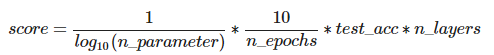

In [31]:
score = 1 / np.log(61886) * 10/15 *  0.99026  * 2

In [32]:
#mejor score:
score

0.11967196332861223